# WGAN: Theory

For notes on the standard GAN please refer to the [[GAN Notebook]](https://github.com/udeepam/gan/blob/master/notebooks/gan.ipynb).

### Wasserstein Distance

The Earth-Mover (EM) distance or Wasserstein-1 is informally defined as the minimum cost of transporting mass in order to transform the distribution $q$ into the distribution $p$, where the cost is mass times transport distance.

Given two probability distributions $p$ and $q$, the Wasserstein-1 distance is defined as

$$W_1(q,p)=\underset{\gamma\in\prod(q,p)}{\text{inf }}\mathbb{E}_{(x,y)\sim\gamma}\Big[\left\Vert x-y\right\Vert\Big]=\underset{\gamma\in\prod(q,p)}{\text{inf }}\int\gamma(x,y)\left\Vert x-y\right\Vert dxdy$$

where 
* $\prod(q,p)$ is the set of all possible joint distributions $\gamma$ for $q$ and $p$ that have marginals $q$ and $p$.
* $\gamma(x,y)\sim\prod(q,p)$ indicates how much mass must be transported from point $x$ to point $y$ in distribution $q$ to transform it into distribution $p$. This means that we require the marginal distributions $\int\gamma(x,y)dx=p(y)$ and $\int\gamma(x,y)dy=q(x)$

*Can think of it as we have distribution $q$ which we want to transform to $p$. Move mass from $q$ to new distribution $r$ that we are trying to make look like $p$.*

**Advantages of the Wasserstein Distance**<br>
The Wasserstein distance is able to provide a meaningful and smooth representation of distance between two distributions with no overlap.

### The Objective Function

The WGAN value function is constructed using the Kantorovich-Rubinstein duality to obtain 

$$\begin{align}
\underset{G}{\text{min }}\underset{D}{\text{max }}V(D,G)&=\mathbb{E}_{\mathbf{x}\sim p_{data}(\mathbf{x})}\Big[\log D(\mathbf{x})\Big] - \mathbb{E}_{\mathbf{z}\sim p_{\mathbf{z}}(\mathbf{z})}\bigg[\log \Big(1-D\big(G(\mathbf{z})\big)\Big)\bigg]\\
&=\mathbb{E}_{\mathbf{x}\sim p_{data}(\mathbf{x})}\Big[\log D(\mathbf{x})\Big]+ \mathbb{E}_{\mathbf{x}\sim p_g(\mathbf{x})}\Big[\log D(\mathbf{x})\Big]
\end{align}$$

### The Training Algorithm

### References:
Original WGAN paper: http://proceedings.mlr.press/v70/arjovsky17a.html<br>
Lilian Weng blog: https://lilianweng.github.io/lil-log/2017/08/20/from-GAN-to-WGAN.html<br>
Mindcodec blog: https://mindcodec.ai//2018/09/19/an-intuitive-guide-to-optimal-transport-part-i-formulating-the-problem/

# WGAN: Code

**Resources**<br>
PyTorch-GAN: https://github.com/eriklindernoren/PyTorch-GAN

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import time
from collections import defaultdict

import torch
import torch.nn as nn
import torch.utils.data as data_utils

# Device Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fix random seeds for reproducibility
seed = 73
torch.manual_seed(seed)
torch.random.manual_seed(seed)
np.random.seed(seed)

%matplotlib inline

## Load MNIST Dataset

In [2]:
# Download MNIST dataset, preprocess and save locally as .npz file
# import torchvision
# from torchvision import transforms
# from torchvision.datasets import MNIST
# # 60000 tuples with 1x28x28 image and corresponding label
# data = MNIST('../data', 
#              train=True, 
#              download=True,
#              transform = transforms.Compose([transforms.ToTensor()]))
# # Split data into images and labels
# x_train = data.train_data
# y_train = data.train_labels
# # Scale images from [0,255] to [-1,+1]
# x_train = ((x_train.float() / 255) - 0.5) * 2
# # Save as .npz
# np.savez_compressed('../data/mnist', 
#                     a=x_train,
#                     b=y_train)

In [3]:
# Load MNIST data locally
data = np.load('../data/mnist.npz')
x_train = torch.Tensor(data['a'])
y_train = torch.Tensor(data['b'])
n_classes = len(np.unique(y_train))

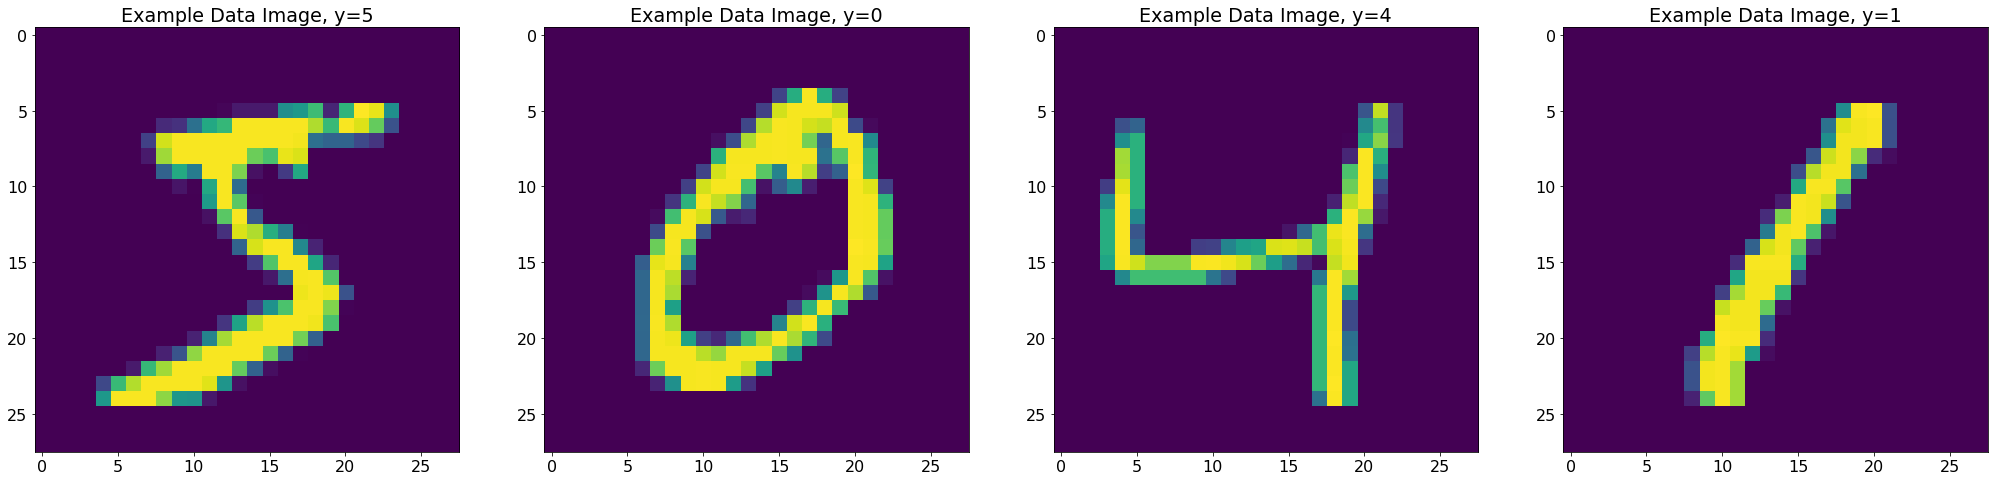

In [4]:
# Visualise data
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(1,4, figsize=(35,35))
imx, imy = (28,28)
labels   = [0,1,2,3]
for i, ax in enumerate(axes):
    visual = np.reshape(x_train[labels[i]], (imx,imy))
    ax.set_title("Example Data Image, y="+str(int(y_train[labels[i]])))
    ax.imshow(visual, vmin=-1, vmax=1)
plt.show()

## Models

In [5]:
class Generator(nn.Module):
    def __init__(self, input_shape, output_shape):
        """
        Generator Model.
        
        Arguments:
        ----------
        input_shape : `int`
            Dimensionality of the latent space. (Default=100)
        output_shape : `int`
            Flattened size of image. (Default=784)
        """
        super(Generator, self).__init__()
        
        def block(in_shape, out_shape, normalize=True):
            layers = [nn.Linear(in_shape, out_shape)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_shape, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers        
        
        self.model = nn.Sequential(*block(input_shape, 128, normalize=False),
                                   *block(128, 256),
                                   *block(256, 512),
                                   *block(512, 1024),
                                   nn.Linear(1024, output_shape),
                                   nn.Tanh())

    def forward(self, z):
        return self.model(z)     

In [6]:
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        """
        Discriminator Model.
        
        Arguments:
        ----------
        input_shape : `int`
            Flattened size of image. (Default=784)
        """        
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(nn.Linear(input_shape, 1024),
                                   nn.Dropout(0.4),
                                   nn.LeakyReLU(0.2, inplace=True),
                                   nn.Linear(1024, 512),
                                   nn.Dropout(0.4),
                                   nn.LeakyReLU(0.2, inplace=True),
                                   nn.Linear(512, 256),
                                   nn.Dropout(0.4),
                                   nn.LeakyReLU(0.2, inplace=True),
                                   nn.Linear(256, 1),
                                   nn.Sigmoid())        

    def forward(self, x):
        x_flat = x.view(x.size(0), -1)    
        return self.model(x_flat)

## Training

In [7]:
# Hyperparameters
n_critics  = 5
clip_value = 0.001
z_dim  = 100
epochs = 200
batch_size = 256
learning_rate = 5e-5

In [8]:
# Create DatatLoader 
dataset    = data_utils.TensorDataset(x_train, y_train)
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=batch_size,
                                         shuffle=True)

# Initialize discriminator and generator
discriminator = Discriminator(np.prod(x_train[0].shape))
generator     = Generator(z_dim, np.prod(x_train[0].shape))

# Optimisers
optimiser_D = torch.optim.RMSprop(discriminator.parameters(), lr=learning_rate)
optimiser_G = torch.optim.RMSprop(generator.parameters(), lr=learning_rate)

# Send to GPU if available
discriminator.to(device)
generator.to(device)

print("Device: ", device)
print(discriminator)
print(generator)

Device:  cuda
Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)
Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchN

In [9]:
# Training
measures = defaultdict(list)
start_time = time.time()
for epoch in range(epochs):
    epoch_start_time = time.time()
    
    batch_loss_g = 0 
    batch_loss_d = 0 
    for i, (X,_) in enumerate(dataloader): 
        X = X.to(device)
        # Adversarial ground truths
        y_true = torch.ones(X.size(0), 1, dtype=torch.float).to(device)
        y_fake = torch.zeros(X.size(0), 1, dtype=torch.float).to(device) 
            
        # Train Generator
        #----------------
        discriminator.eval()
        generator.train()        
        
        # Zero accumulated gradients
        generator.zero_grad()
        
        # Sample noise as generator input
        z = torch.FloatTensor(np.random.normal(0, 1, (X.shape[0], z_dim))).to(device)  
        # Generate a batch of images
        gen_X = generator(z)
        
        # Calculate loss
        g_loss = adversarial_loss(discriminator(gen_X), y_true)
        # Backpropogation: calculating gradients
        g_loss.backward()
        # Update parameters of generator
        optimiser_G.step()  
    
        # Train Discriminator
        #----------------    
        discriminator.train()
        generator.eval()     
                
        # Zero accumulated gradients
        discriminator.zero_grad()  

        # Calculate loss           
        true_loss = adversarial_loss(discriminator(X), y_true)
        fake_loss = adversarial_loss(discriminator(gen_X.detach()), y_fake)
        d_loss = true_loss + fake_loss
        # Backpropogation: calculating gradients
        d_loss.backward()
        # Update parameters of discriminator
        optimiser_D.step() 
        
        # Save loss per batch
        batch_loss_g += g_loss.item()*X.size(0)          
        batch_loss_d += d_loss.item()*X.size(0)            
           
    # Save losses per epoch
    measures['total_loss_g'].append(batch_loss_g / len(dataloader.dataset))
    measures['total_loss_d'].append(batch_loss_d / len(dataloader.dataset)) 
  
    # Save `n_classes` images produced every epoch
    if epoch ==0 or (epoch+1)%4== 0:
        indices = np.random.randint(0,X.size(0),n_classes)
        measures['images'].append(gen_X[indices].detach().cpu().numpy())      
    
    print("Epoch: {}/{}...".format(epoch+1, epochs),
          "D Loss: {:.4f}...".format(measures['total_loss_d'][-1]),
          "G Loss: {:.4f}...".format(measures['total_loss_g'][-1]),
          "Time Taken: {:,.4f} seconds".format(time.time()-epoch_start_time))    
    
print("Total Time Taken: {:,.4f} seconds".format(time.time()-start_time))

Epoch: 1/200... D Loss: 0.9157... G Loss: 0.5818... Time Taken: 1.0492 seconds
Epoch: 2/200... D Loss: 1.1535... G Loss: 0.5834... Time Taken: 0.9519 seconds
Epoch: 3/200... D Loss: 0.4741... G Loss: 1.4233... Time Taken: 0.9543 seconds
Epoch: 4/200... D Loss: 0.2675... G Loss: 1.8306... Time Taken: 1.0132 seconds
Epoch: 5/200... D Loss: 0.3674... G Loss: 1.3165... Time Taken: 0.9573 seconds
Epoch: 6/200... D Loss: 0.4713... G Loss: 1.0082... Time Taken: 0.9838 seconds
Epoch: 7/200... D Loss: 0.1434... G Loss: 2.0962... Time Taken: 0.9526 seconds
Epoch: 8/200... D Loss: 0.1163... G Loss: 2.3079... Time Taken: 0.9815 seconds
Epoch: 9/200... D Loss: 0.2571... G Loss: 1.6072... Time Taken: 0.9504 seconds
Epoch: 10/200... D Loss: 0.1772... G Loss: 1.9645... Time Taken: 0.9544 seconds
Epoch: 11/200... D Loss: 0.1410... G Loss: 2.4013... Time Taken: 1.0034 seconds
Epoch: 12/200... D Loss: 0.1229... G Loss: 4.9497... Time Taken: 0.9555 seconds
Epoch: 13/200... D Loss: 0.2357... G Loss: 10.276

Epoch: 104/200... D Loss: 0.4315... G Loss: 4.4579... Time Taken: 0.9534 seconds
Epoch: 105/200... D Loss: 0.4306... G Loss: 5.9269... Time Taken: 0.9561 seconds
Epoch: 106/200... D Loss: 0.4046... G Loss: 4.9867... Time Taken: 0.9915 seconds
Epoch: 107/200... D Loss: 0.3455... G Loss: 3.4697... Time Taken: 0.9587 seconds
Epoch: 108/200... D Loss: 0.3476... G Loss: 3.1297... Time Taken: 0.9890 seconds
Epoch: 109/200... D Loss: 0.4426... G Loss: 3.2754... Time Taken: 0.9634 seconds
Epoch: 110/200... D Loss: 0.2139... G Loss: 4.0387... Time Taken: 0.9682 seconds
Epoch: 111/200... D Loss: 0.1705... G Loss: 3.2284... Time Taken: 0.9873 seconds
Epoch: 112/200... D Loss: 0.3500... G Loss: 2.9577... Time Taken: 0.9549 seconds
Epoch: 113/200... D Loss: 0.4552... G Loss: 2.6772... Time Taken: 0.9992 seconds
Epoch: 114/200... D Loss: 0.6134... G Loss: 2.6300... Time Taken: 0.9583 seconds
Epoch: 115/200... D Loss: 0.4819... G Loss: 3.1232... Time Taken: 0.9902 seconds
Epoch: 116/200... D Loss: 1.

## Results

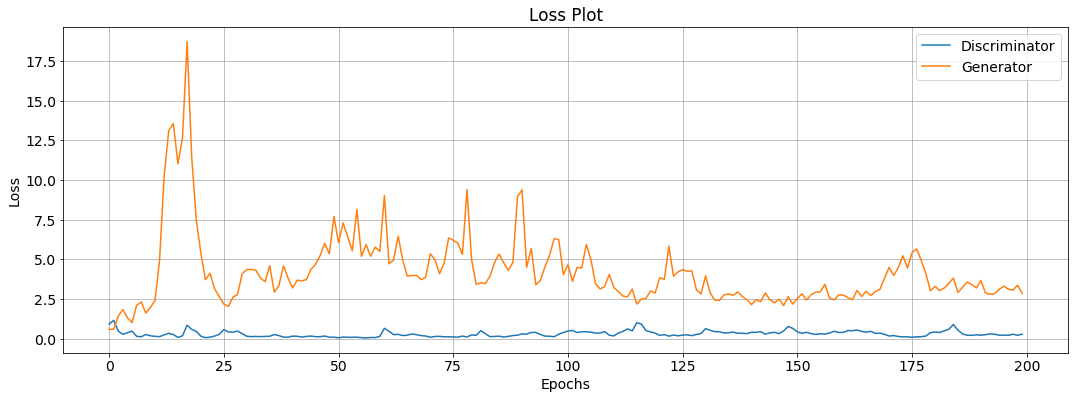

In [10]:
# Plot loss
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(18,6))
plt.plot(measures['total_loss_d'], label='Discriminator')
plt.plot(measures['total_loss_g'], label='Generator')
plt.title('Loss Plot')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

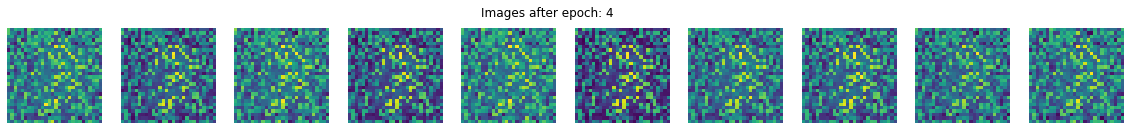

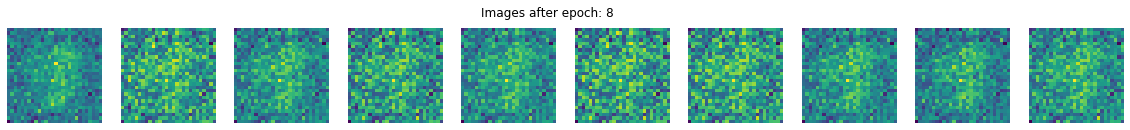

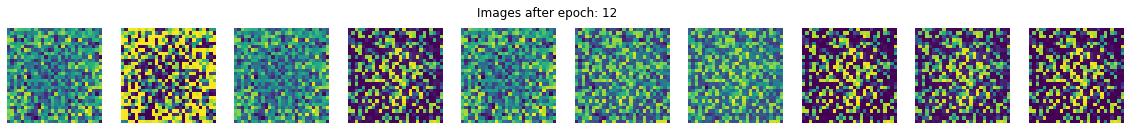

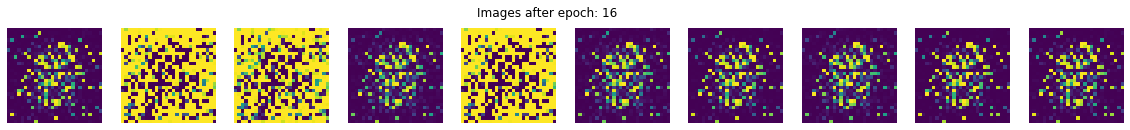

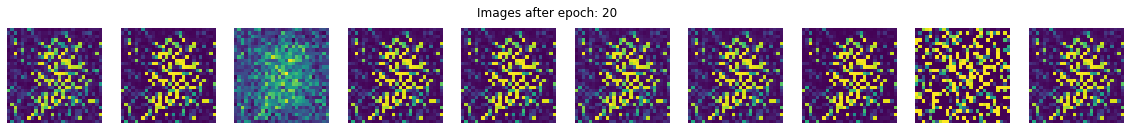

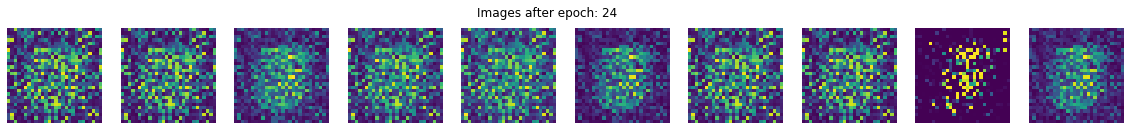

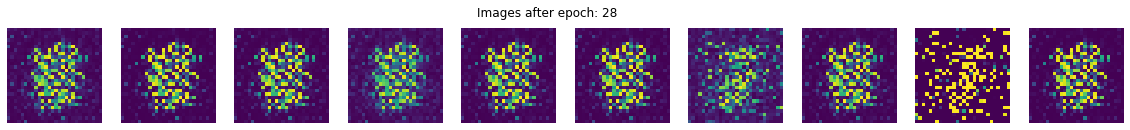

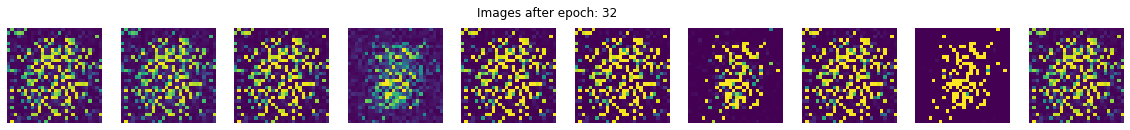

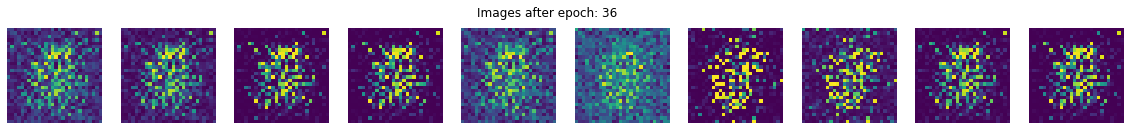

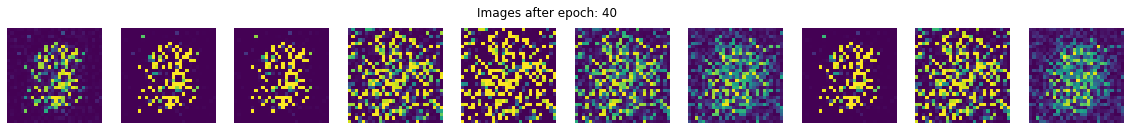

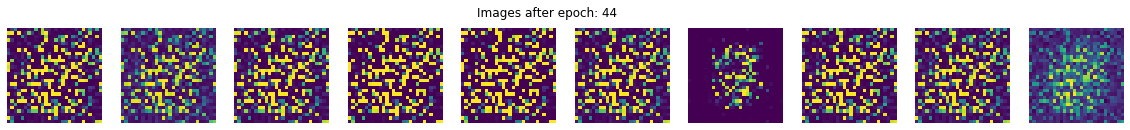

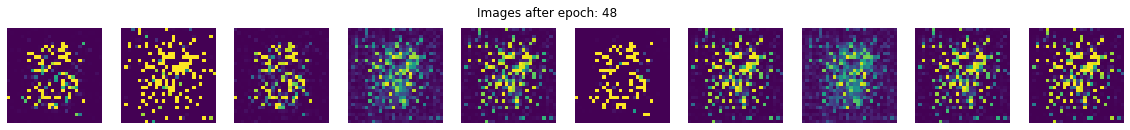

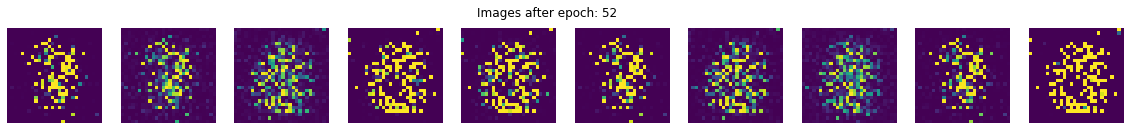

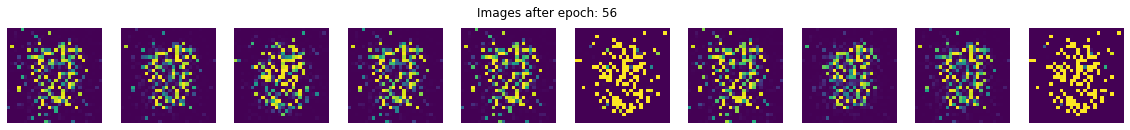

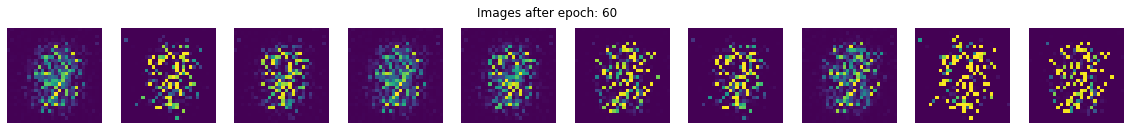

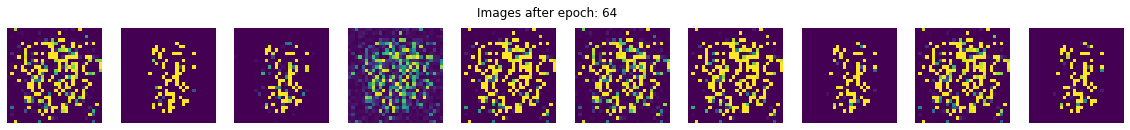

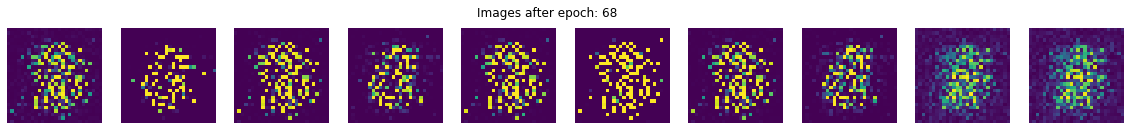

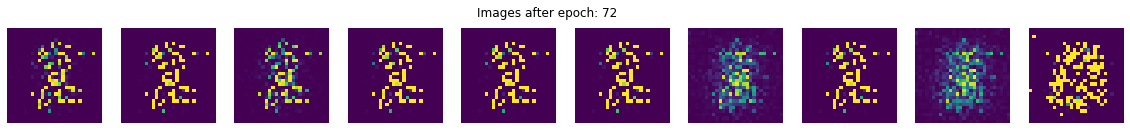

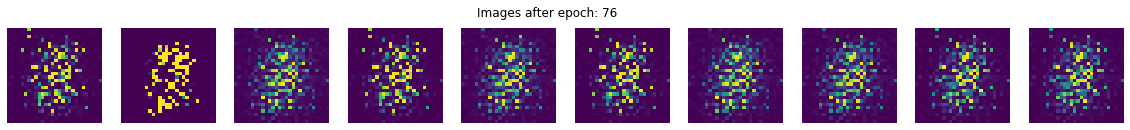

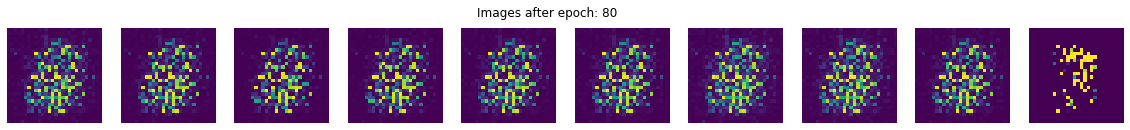

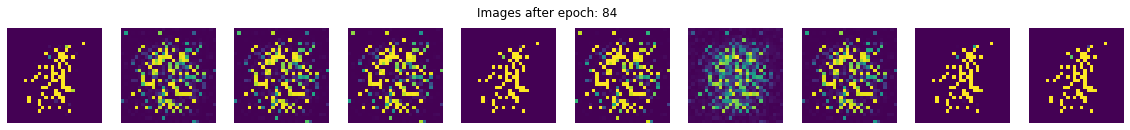

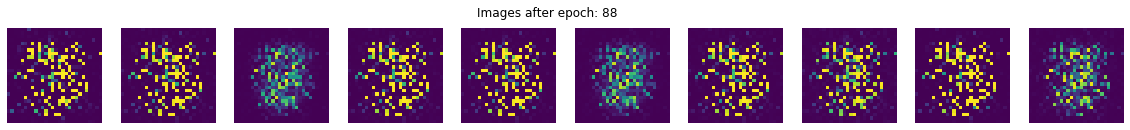

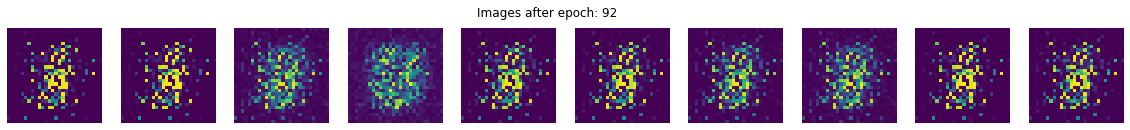

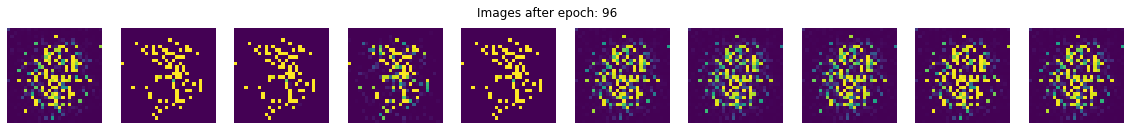

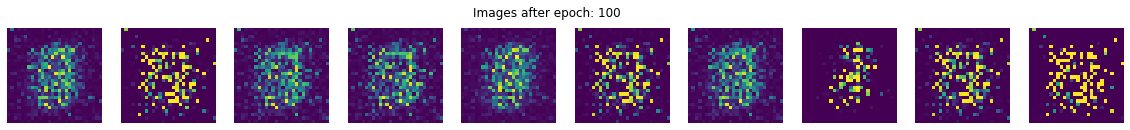

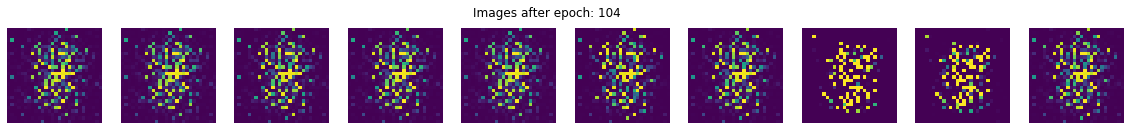

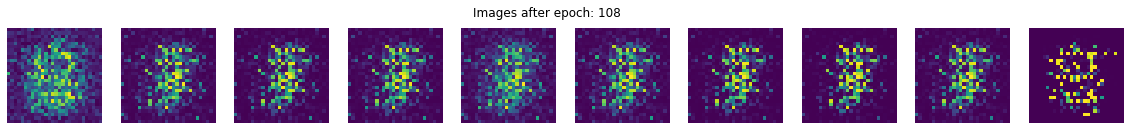

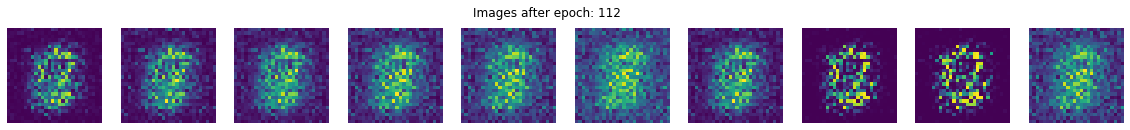

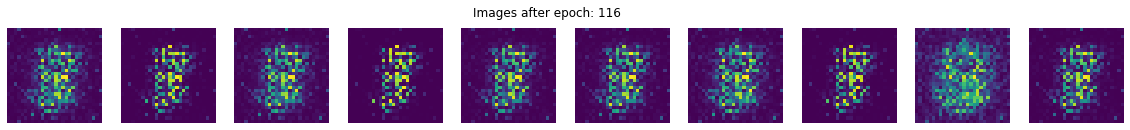

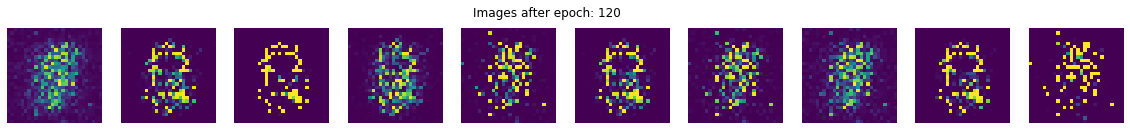

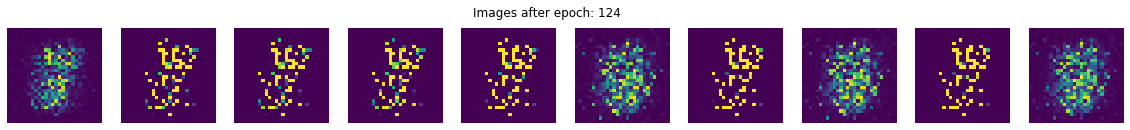

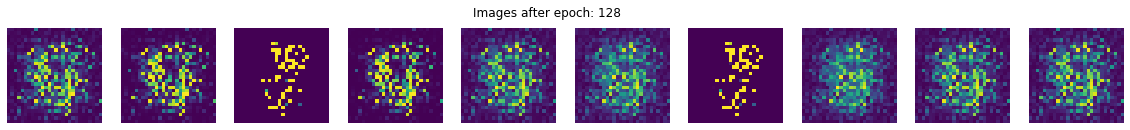

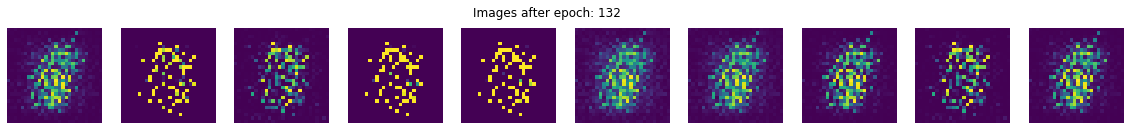

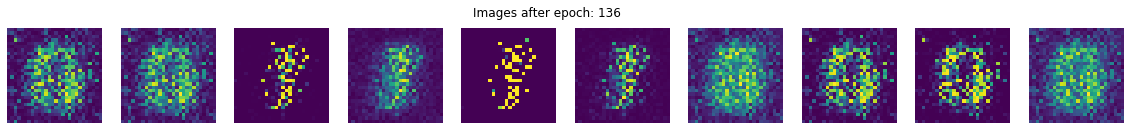

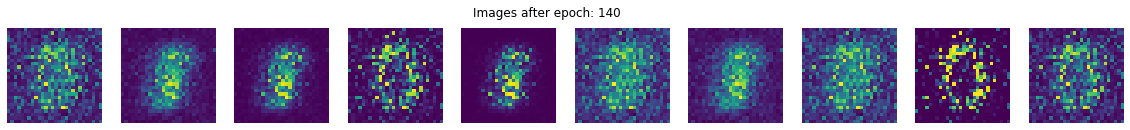

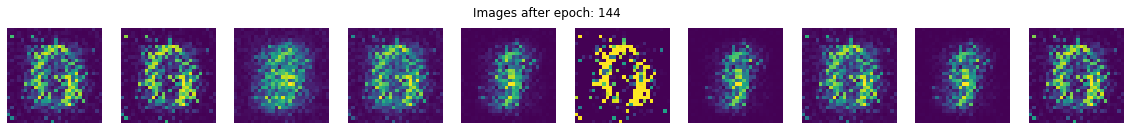

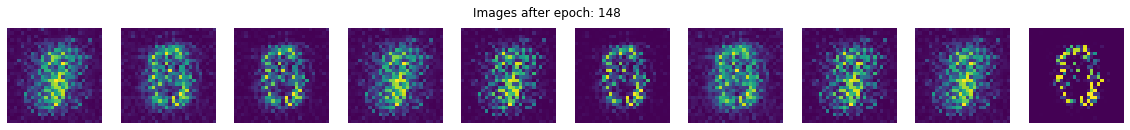

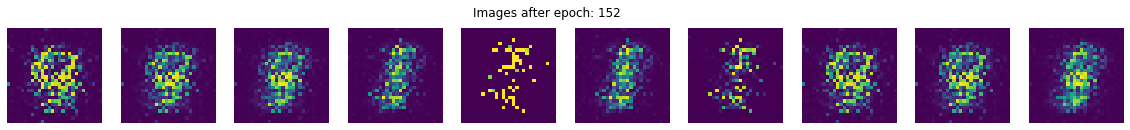

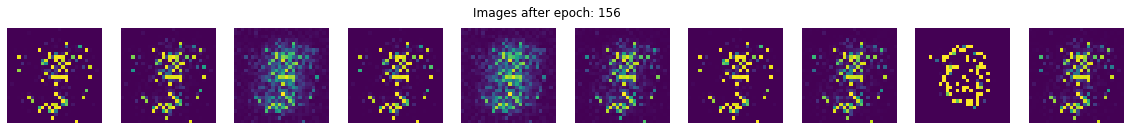

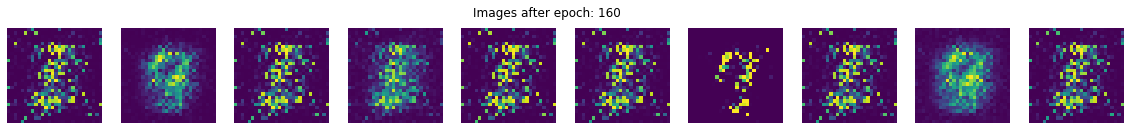

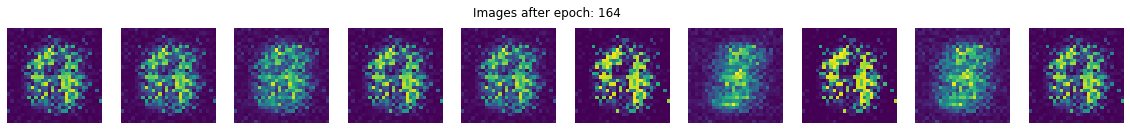

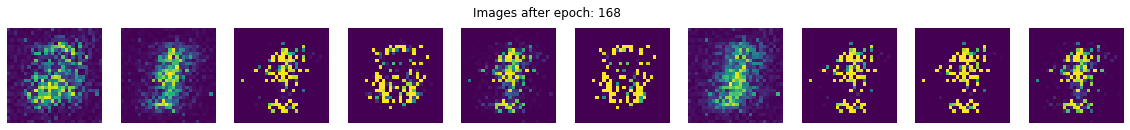

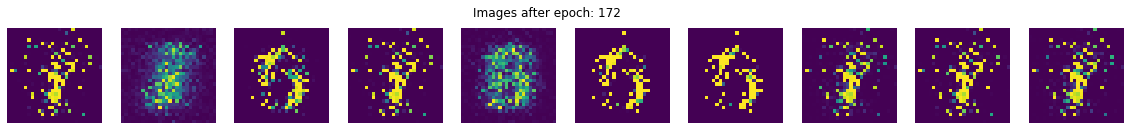

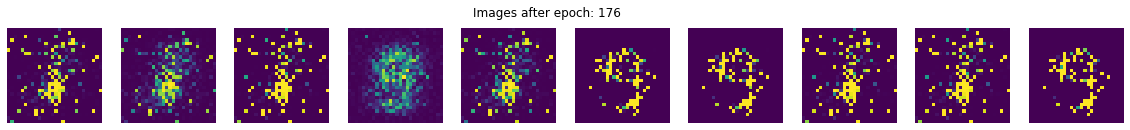

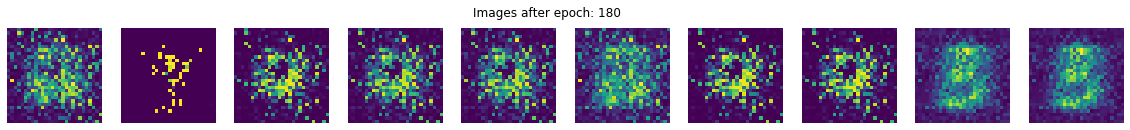

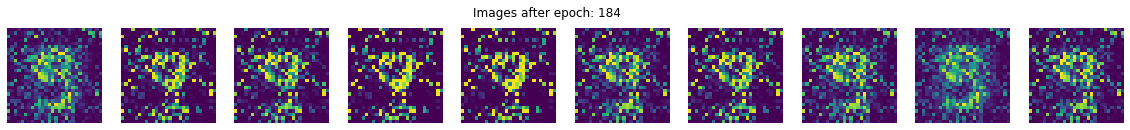

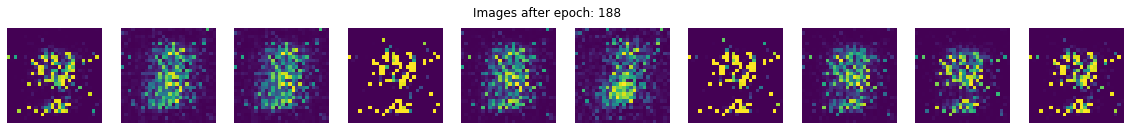

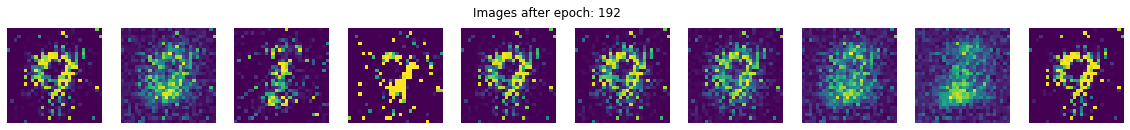

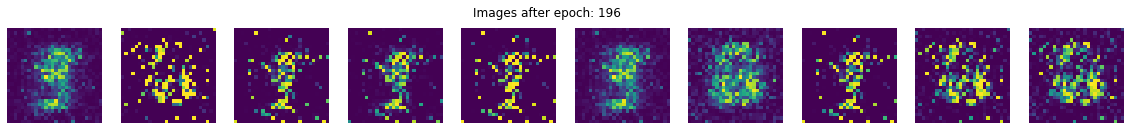

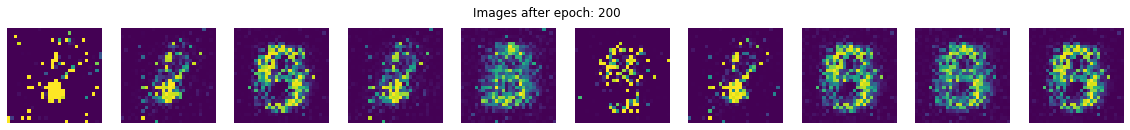

In [11]:
# Plot images generated by Generator
plt.rcParams.update({'font.size': 10})
imx, imy = (28,28)
for i, imgs in enumerate(measures['images']):
    fig, axs = plt.subplots(1, n_classes, figsize=(20,2)) 
    for j, img in enumerate(imgs):
        visual = np.reshape(img, (imx,imy))
        axs[j].imshow(visual)
        axs[j].axis('off')
    label = i+1 if i==0 else 4*i
    plt.suptitle('Images after epoch: %s' %label)
    plt.show()